# `MultiModel` framework

Here we showcase the `MultiModel` framework, a standalone framework within `neurolib` to create and simulate heterogeneous brain models. By heterogeneous, we mean that a brain network may consist of nodes with totally different dynamics coupled by a single variable. Imagine having a population model for the thalamus, a different model for the hippocampus, and a different model for the cortex. Of course, the parameters and the model dynamics, and the equations would be completely different. This is all possible and even relatively easy in `MultiModel`.

## Implemented models
To facilitate your heterogeneous experiments, the `MultiModel` comes with few population models predefined for you. We can mix these into a brain network in many ways. We provide:

* `aln`: the adaptive linear-nonlinear population model, it is a mean-field approximation of delay-coupled network of excitatory and inhibitory adaptive exponential integrate-and-fire neurons (AdEx)
* `fitzhugh_nagumo`: the FitzHugh-Nagumo model, a two-dimensional slow-fast system, is a simplified version of the famous 4D Hodgkin–Huxley model
* `hopf`: the Hopf model (sometimes called a Stuart-Landau oscillator) is a 1D nonlinear model and serves as a normal form of Hopf bifurcation in dynamical systems
* `thalamus`: a conductance-based population rate model of the thalamus, it is a Jansen-Rit like population model with current-based voltage evolution, includes adaptation (*K*-leak), calcium, and rectifying currents
* `wilson_cowan`: the Wilson-Cowan neuronal model is a simple model of interacting interconnected neurons of excitatory and inhibitory subtypes
* `wong_wang`: a Wong-Wang model, a model approximating a biophysically-based cortical network model. Our implementation comes in two flavors:
    * original Wong-Wang model with excitatory and inhibitory subtypes
    * reduced Wong-Wang model with simpler dynamics and no EXC/INH distinction
    
Moreover, the `MultiModel` framework is built in such a way that creating and connecting new models (e.g., Jansen-Rit) is easy and intuitive. An example of how to make a brand new model implementation in `MultiModel` is provided in the following example notebook (`example-4.1-create-new-model.ipynb`).

## Modeling hierarchy
The `MultiModel` relies on the modeling hierarchy, which is typically implicit in whole-brain modeling. This hierarchy has three levels:
* `NeuralMass`: represents a single neural population (typically excitatory, inhibitory, or without a subtype) and is defined by a set of parameters and (possibly delayed) (possibly stochastic) differential equations
* `Node`: represents a single brain node, and it is a set of connected neural masses (so, e.g., a single Wilson-Cowan node consists of one excitatory and one inhibitory Wilson-Cowan `NeuralMass`)
* `Network`: represents a brain network, and it is a set of connected nodes (can be any type, as long as the coupling variables are the same)

Although the magic happens at the level of `NeuralMass` (by magic, we mean the dynamics), users can only simulate (integrate) a `Node` or a `Network`. In other words, even for models without excitatory/inhibitory subtyping (e.g., Hopf or FitzHugh-Nagumo), we create a `Node` consisting of one `NeuralMass`. In the case of, e.g., Wilson-Cowan, ALN, or original Wong-Wang model, the `Node` consists of one excitatory and one inhibitory mass. More info on the modeling hierarchy and how it actually works is provided in the following example notebook (`example-4.1-create-new-model.ipynb`), where we need to subclass the base classes for this hierarchy to build a new model.

## Basic usage in `neurolib`
(In the following we expect the reader to be mildly familiar with how `neurolib` works, e.g. how to run a model, how to change it parameters, and how to get model results)

In [3]:
# import stuff

# try:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# import ALN single node model and neurolib wrapper `MultiModel`
from neurolib.models.multimodel import ALNNetwork, ALNNode, MultiModel

# except ImportError:
#     import sys
#     !{sys.executable} -m pip install matplotlib
#     import matplotlib.pyplot as plt

## Simulating the node

/Users/caglar/anaconda/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
100%|██████████| 5000/5000 [00:00<00:00, 6165.93it/s]


Text(0, 0.5, 'Rate [kHz]')

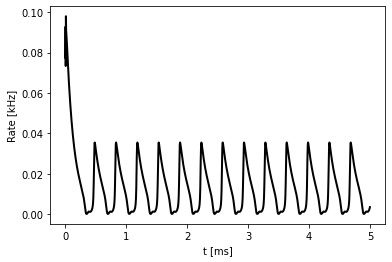

In [5]:
# create a model and wrap it to `MultiModel`
aln = MultiModel.init_node(ALNNode())

# 5 seconds run
aln.params["duration"] = 5.0 * 1000  # in ms
# MultiModel offers two integration backends, be default we are using so-called `jitcdde` backend
# `jitcdde` is a numerical backend employing adaptive dt scheme for DDEs, therefore we do not care about
# actual dt (since it is adaptive), only about the sampling dt and this can be higher
# more about this in example-4.2
aln.params["sampling_dt"] = 1.0  # in ms
# parametrise ALN model in slow limit cycle
aln.params["*EXC*input*mu"] = 4.2
aln.params["*INH*input*mu"] = 1.8
# run
aln.run()

# plot - default output is firing rates in kHz
plt.plot(aln["t"], aln["r_mean_EXC"].T, lw=2, c="k")
plt.xlabel("t [ms]")
plt.ylabel("Rate [kHz]")

As you saw in the previous cell, the internal workings of `MultiModel` are very similar to the core `neurolib`. Therefore, for simple runs, you do care about the following:
* `MultiModel`: a wrapper class for all models in MultiModel framework which gives model objects `neurolib` powers (meaning `.params` and `.run()`). `MultiModel` class is initialized as follows:
    * when initialising with `Node`: `model = MultiModel.init_node(<init'd Node class>)`
    * when initialising with `Network`: `model = MultiModel(<init'd Network class>)` (see later)
    
## `MultiModel` parameters and other accessible attributes
Since `MultiModel` is able to simulate heterogeneous models, the internals of how parameters work is a bit more complex than in the core `neurolib`. Each mass has its own parameters, each node then gathers the parameters of each mass within that node, and finally, the network gathers all parameters from each node in the network, etc. So hierarchy again. To make it easier to navigate through `MultiModel` hierarchies, some attributes are implemented in all hierarchy levels.

In [6]:
dummy_sc = np.array([[0.0, 1.0], [1.0, 0.0]])
# init MultiModelnetwork with 2 ALN nodes with dummy sc and no delays
mm_net = ALNNetwork(connectivity_matrix=dummy_sc, delay_matrix=None)

print(mm_net)
# each network is an proper python iterator, i.e. len() is defined
print(f"Nodes: {len(mm_net)}")
# as well as __get_item__
print(mm_net[0])
print(mm_net[1])
# similarly, each node is a python iterator, i.e.
print(f"Masses in 1. node: {len(mm_net[0])}")
print(mm_net[0][0])
print(mm_net[0][1])

# in order to navigate through the hierarchy, each mass, node and net
# has its own name and label and index
# index of a node is relative within the network
# index of a mass is relative within the node
print(f"This network name: {mm_net.name}")
print(f"This network label: {mm_net.label}")
print(f"1st node name: {mm_net[0].name}")
print(f"1st node label: {mm_net[0].label}")
print(f"1st node index: {mm_net[0].index}")
print(f"1st mass in 1st node name: {mm_net[0][0].name}")
print(f"1st mass in 1st node label: {mm_net[0][0].label}")
print(f"1st mass in 1st node index: {mm_net[0][0].index}")

# you can also check number of variables etc at all levels of hierarchy
print(f"ALN EXC num. vars: {mm_net[0][0].num_state_variables}")
print(f"ALN INH num. vars: {mm_net[0][1].num_state_variables}")
print(f"ALN node num. vars: {mm_net[0].num_state_variables}")
print(f"This network num. vars: {mm_net.num_state_variables}")
# similarly you can check number of "noise variables", i.e. the number
# of stochastic variables entering the simulation
print(f"ALN EXC noise vars: {mm_net[0][0].num_noise_variables}")
# etc

# not sure what are the state variables? no problem!
print(f"ALN EXC state vars: {mm_net[0][0].state_variable_names}")
print(f"ALN node state vars: {mm_net[0].state_variable_names}")
print(f"This network state vars: {mm_net.state_variable_names}")

# if you are unsure what kind of a monster you build in MultiModel,
# a function `describe()` is available at all three levels -
# it returns a dictionary with basic info about the model object
# this is describe of a `NeuralMass`
print("")
print("Mass `describe`:")
display(mm_net[0][0].describe())
# describe of a `Node` recursively describes all masses and some more
print("")
print("Node `describe`:")
display(mm_net[0].describe())
# and finally, describe of a `Network` gives you everything
print("")
print("Network `describe`:")
display(mm_net.describe())

# PRO tip: imagine highly heterogeneous network and some long simulation with it;
# apart from the results you can dump `net.describe()` dictionary into json and
# never forget what you've done!

Brain network ALN neural mass network with 2 nodes
Nodes: 2
Network node: ALN neural mass node with 2 neural masses: ALN excitatory neural mass EXC, ALN inhibitory neural mass INH
Network node: ALN neural mass node with 2 neural masses: ALN excitatory neural mass EXC, ALN inhibitory neural mass INH
Masses in 1. node: 2
Neural mass: ALN excitatory neural mass with 7 state variables: I_mu, I_A, I_syn_mu_exc, I_syn_mu_inh, I_syn_sigma_exc, I_syn_sigma_inh, r_mean
Neural mass: ALN inhibitory neural mass with 6 state variables: I_mu, I_syn_mu_exc, I_syn_mu_inh, I_syn_sigma_exc, I_syn_sigma_inh, r_mean
This network name: ALN neural mass network
This network label: ALNNet
1st node name: ALN neural mass node
1st node label: ALNNode
1st node index: 0
1st mass in 1st node name: ALN excitatory neural mass
1st mass in 1st node label: ALNMassEXC
1st mass in 1st node index: 0
ALN EXC num. vars: 7
ALN INH num. vars: 6
ALN node num. vars: 13
This network num. vars: 26
ALN EXC noise vars: 1
ALN EXC sta

{'index': 0,
 'name': 'ALN excitatory neural mass',
 'mass_type': 'EXC',
 'num_state_variables': 7,
 'num_noise_variables': 1,
 'state_variable_names': ['I_mu',
  'I_A',
  'I_syn_mu_exc',
  'I_syn_mu_inh',
  'I_syn_sigma_exc',
  'I_syn_sigma_inh',
  'r_mean'],
 'params': {'Ke': 800.0,
  'Ki': 200.0,
  'c_gl': 0.4,
  'Ke_gl': 250.0,
  'tau_se': 2.0,
  'tau_si': 5.0,
  'sigmae_ext': 1.5,
  'Jee_max': 2.43,
  'Jei_max': -3.3,
  'C': 200.0,
  'gL': 10.0,
  'ext_exc_current': 0.0,
  'ext_exc_rate': 0.0,
  'a': 15.0,
  'b': 40.0,
  'EA': -80.0,
  'tauA': 200.0,
  'lambda': 10.0,
  'input_0': {'type': 'OrnsteinUhlenbeckProcess',
   'mu': 4.2,
   'sigma': 0.0,
   'tau': 5.0,
   'n': 1,
   'seed': None}},
 'lin_nonlin_transfer_function_filename': '/Users/caglar/anaconda/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5'}


Node `describe`:


{'index': 0,
 'name': 'ALN neural mass node',
 'num_masses': 2,
 'num_num_state_variables': 13,
 'num_noise_variables': 2,
 'masses': [{'index': 0,
   'name': 'ALN excitatory neural mass',
   'mass_type': 'EXC',
   'num_state_variables': 7,
   'num_noise_variables': 1,
   'state_variable_names': ['I_mu',
    'I_A',
    'I_syn_mu_exc',
    'I_syn_mu_inh',
    'I_syn_sigma_exc',
    'I_syn_sigma_inh',
    'r_mean'],
   'params': {'Ke': 800.0,
    'Ki': 200.0,
    'c_gl': 0.4,
    'Ke_gl': 250.0,
    'tau_se': 2.0,
    'tau_si': 5.0,
    'sigmae_ext': 1.5,
    'Jee_max': 2.43,
    'Jei_max': -3.3,
    'C': 200.0,
    'gL': 10.0,
    'ext_exc_current': 0.0,
    'ext_exc_rate': 0.0,
    'a': 15.0,
    'b': 40.0,
    'EA': -80.0,
    'tauA': 200.0,
    'lambda': 10.0,
    'input_0': {'type': 'OrnsteinUhlenbeckProcess',
     'mu': 4.2,
     'sigma': 0.0,
     'tau': 5.0,
     'n': 1,
     'seed': None}},
   'lin_nonlin_transfer_function_filename': '/Users/caglar/anaconda/lib/python3.7/site-pa


Network `describe`:


{'name': 'ALN neural mass network',
 'num_nodes': 2,
 'num_state_variables': 26,
 'num_noise_variables': 4,
 'nodes': [{'index': 0,
   'name': 'ALN neural mass node',
   'num_masses': 2,
   'num_num_state_variables': 13,
   'num_noise_variables': 2,
   'masses': [{'index': 0,
     'name': 'ALN excitatory neural mass',
     'mass_type': 'EXC',
     'num_state_variables': 7,
     'num_noise_variables': 1,
     'state_variable_names': ['I_mu',
      'I_A',
      'I_syn_mu_exc',
      'I_syn_mu_inh',
      'I_syn_sigma_exc',
      'I_syn_sigma_inh',
      'r_mean'],
     'params': {'Ke': 800.0,
      'Ki': 200.0,
      'c_gl': 0.4,
      'Ke_gl': 250.0,
      'tau_se': 2.0,
      'tau_si': 5.0,
      'sigmae_ext': 1.5,
      'Jee_max': 2.43,
      'Jei_max': -3.3,
      'C': 200.0,
      'gL': 10.0,
      'ext_exc_current': 0.0,
      'ext_exc_rate': 0.0,
      'a': 15.0,
      'b': 40.0,
      'EA': -80.0,
      'tauA': 200.0,
      'lambda': 10.0,
      'input_0': {'type': 'OrnsteinUhlen

In [7]:
# now let us check the parameters.. for this we initialise MultiModel in neurolib's fashion
aln_net = MultiModel(mm_net)
# parameters are accessible via .params
aln_net.params
# as you can see the parameters are flattened nested dictionary which follows this nomenclature
# {"<network label>.<node label>_index.<mass label>_index.<param name>: param value"}

{'ALNNet.ALNNode_0.ALNMassEXC_0.Ke': 800.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.Ki': 200.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.c_gl': 0.4,
 'ALNNet.ALNNode_0.ALNMassEXC_0.Ke_gl': 250.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tau_se': 2.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tau_si': 5.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.sigmae_ext': 1.5,
 'ALNNet.ALNNode_0.ALNMassEXC_0.Jee_max': 2.43,
 'ALNNet.ALNNode_0.ALNMassEXC_0.Jei_max': -3.3,
 'ALNNet.ALNNode_0.ALNMassEXC_0.C': 200.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.gL': 10.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.ext_exc_current': 0.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.ext_exc_rate': 0.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.a': 15.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.b': 40.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.EA': -80.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tauA': 200.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.lambda': 10.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.type': 'OrnsteinUhlenbeckProcess',
 'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.mu': 4.2,
 'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.sigm

In [8]:
# as you can see there are a lot of parameters for simple 2-node network of ALN models
# typically you want to change parameters of all nodes at the same time
# fortunately, model.params is not your basic dictionary, it's a special one, we call it `star` dictionary,
# because you can do this:
display(aln_net.params["*tau"])
print("")
# so yes, star works as a glob identifier, so by selecting "*tau" I want all parameters named tau
# (I dont care from which mass or node it comes)
# what if I want to change taus only in EXC masses? easy:
display(aln_net.params["*EXC*tau"])
print("")
# or maybe I want to change taus only in the first node?
display(aln_net.params["*Node_0*tau"])
print("")
# of course, you can change a param value with this
aln_net.params["*Node_0*tau"] = 13.2
display(aln_net.params["*Node_0*tau"])
aln_net.params["*Node_0*tau"] = 5.0

{'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.tau': 5.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.input_0.tau': 5.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.input_0.tau': 5.0,
 'ALNNet.ALNNode_1.ALNMassINH_1.input_0.tau': 5.0}

{'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.tau': 5.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.input_0.tau': 5.0}

{'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.tau': 5.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.input_0.tau': 5.0}

{'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.tau': 13.2,
 'ALNNet.ALNNode_0.ALNMassINH_1.input_0.tau': 13.2}

In [9]:
# case: I want to change all taus except "noise" taus
# this gives all the taus, including "noise"
display(aln_net.params["*tau*"])
print("")
# pipe symbol filters out unwanted keys - here we have only taus which key does NOT include "input"
display(aln_net.params["*tau*|input"])

{'ALNNet.ALNNode_0.ALNMassEXC_0.tau_se': 2.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tau_si': 5.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tauA': 200.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.input_0.tau': 5.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.tau_se': 2.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.tau_si': 5.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.input_0.tau': 5.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.tau_se': 2.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.tau_si': 5.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.tauA': 200.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.input_0.tau': 5.0,
 'ALNNet.ALNNode_1.ALNMassINH_1.tau_se': 2.0,
 'ALNNet.ALNNode_1.ALNMassINH_1.tau_si': 5.0,
 'ALNNet.ALNNode_1.ALNMassINH_1.input_0.tau': 5.0}

{'ALNNet.ALNNode_0.ALNMassEXC_0.tau_se': 2.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tau_si': 5.0,
 'ALNNet.ALNNode_0.ALNMassEXC_0.tauA': 200.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.tau_se': 2.0,
 'ALNNet.ALNNode_0.ALNMassINH_1.tau_si': 5.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.tau_se': 2.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.tau_si': 5.0,
 'ALNNet.ALNNode_1.ALNMassEXC_0.tauA': 200.0,
 'ALNNet.ALNNode_1.ALNMassINH_1.tau_se': 2.0,
 'ALNNet.ALNNode_1.ALNMassINH_1.tau_si': 5.0}

In [10]:
max_rate_e = []
min_rate_e = []

# number low for testing:
mue_inputs = np.linspace(0, 2, 2)
# use: mue_inputs = np.linspace(0, 2, 20)

# not let's match ALN parameters to those in example-0-aln-minimal and recreate
# the 1D bif. diagram
aln.params["*INH*input*mu"] = 0.5
aln.params["*b"] = 0.0
aln.params["ALNNode_0.ALNMassEXC_0.a"] = 0.0
for mue in mue_inputs:
    aln.params["*EXC*input*mu"] = mue
    display(aln.params["*EXC*input*mu"])
    aln.run()
    max_rate_e.append(np.max(aln.output[0, -int(1000 / aln.params["sampling_dt"]) :]))
    min_rate_e.append(np.min(aln.output[0, -int(1000 / aln.params["sampling_dt"]) :]))

{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.0}

/Users/caglar/anaconda/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
100%|██████████| 5000/5000 [00:00<00:00, 8890.66it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.10526315789473684}

100%|██████████| 5000/5000 [00:00<00:00, 7656.96it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.21052631578947367}

100%|██████████| 5000/5000 [00:00<00:00, 10956.43it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.3157894736842105}

100%|██████████| 5000/5000 [00:00<00:00, 10739.89it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.42105263157894735}

100%|██████████| 5000/5000 [00:00<00:00, 11081.37it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.5263157894736842}

100%|██████████| 5000/5000 [00:00<00:00, 6348.78it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.631578947368421}

100%|██████████| 5000/5000 [00:01<00:00, 3250.17it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.7368421052631579}

100%|██████████| 5000/5000 [00:01<00:00, 3066.30it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.8421052631578947}

100%|██████████| 5000/5000 [00:01<00:00, 2686.05it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 0.9473684210526315}

100%|██████████| 5000/5000 [00:01<00:00, 2847.63it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.0526315789473684}

100%|██████████| 5000/5000 [00:01<00:00, 2991.07it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.1578947368421053}

Using default integration parameters.
100%|██████████| 5000/5000 [00:01<00:00, 2886.05it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.263157894736842}

100%|██████████| 5000/5000 [00:01<00:00, 4315.20it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.3684210526315788}

100%|██████████| 5000/5000 [00:00<00:00, 8352.61it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.4736842105263157}

100%|██████████| 5000/5000 [00:00<00:00, 9912.85it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.5789473684210527}

100%|██████████| 5000/5000 [00:00<00:00, 10614.61it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.6842105263157894}

100%|██████████| 5000/5000 [00:00<00:00, 10739.93it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.789473684210526}

100%|██████████| 5000/5000 [00:00<00:00, 10708.29it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 1.894736842105263}

Using default integration parameters.
100%|██████████| 5000/5000 [00:00<00:00, 6660.91it/s]


{'ALNNode_0.ALNMassEXC_0.input_0.mu': 2.0}

100%|██████████| 5000/5000 [00:00<00:00, 7579.61it/s]


Text(0, 0.5, 'Min / max firing rate [kHz]')

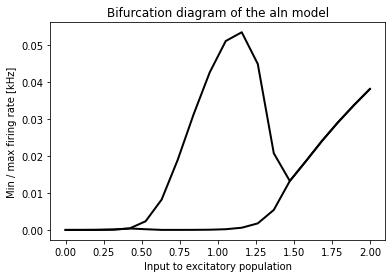

In [11]:
plt.plot(mue_inputs, max_rate_e, c="k", lw=2)
plt.plot(mue_inputs, min_rate_e, c="k", lw=2)
plt.title("Bifurcation diagram of the aln model")
plt.xlabel("Input to excitatory population")
plt.ylabel("Min / max firing rate [kHz]")

## Connecting two models
So far, we only showed how to use `MultiModel` with a single dynamical model (ALN), and that is no fun. I mean, all this is already possible in core `neurolib`, and it the core, it is much faster.

However, the real strength of `MultiModel` is combining different models into one network. Let us build a thalamocortical model using one node of the thalamic population model and one node of ALN, representing the cortex.

In [12]:
# first - imports
from neurolib.models.multimodel import ALNNode, ThalamicNode
from neurolib.models.multimodel.builder.base.constants import EXC, INH
from neurolib.models.multimodel.builder.base.network import Network

In [13]:
# let us start by subclassing the Network


class ALNThalamusMiniNetwork(Network):
    """
    Simple thalamocortical motif: 1 cortical node ALN + 1 NMM thalamus.
    """

    # provide basic attributes as name and label
    name = "ALN 1 node + Thalamus"
    label = "ALNThlmNet"

    # define which variables are used to sync, i.e. what coupling variables our nodes need
    sync_variables = [
        # both nodes are connected via excitatory synapses
        "network_exc_exc",
        # ALN requires also squared coupling
        "network_exc_exc_sq",
        # and INH mass in thalamus also receives excitatory coupling
        "network_inh_exc",
    ]

    # lastly, we need to define what is default output of the network (this has to be the
    #     variable present in all nodes)
    # for us it is excitatory firing rates
    default_output = f"r_mean_{EXC}"
    # define all output vars of any interest to us - EXC and INH firing rates and adaptive current in ALN
    output_vars = [f"r_mean_{EXC}", f"r_mean_{INH}", f"I_A_{EXC}"]

    def __init__(self, connectivity_matrix, delay_matrix):
        # self connections are resolved within nodes, so zeroes at the diagonal
        assert np.all(np.diag(connectivity_matrix) == 0.0)

        # init ALN node with index 0
        aln_node = ALNNode()
        aln_node.index = 0
        # index where the state variables start - for first node it is always 0
        aln_node.idx_state_var = 0
        # set correct indices for noise input
        for mass in aln_node:
            mass.noise_input_idx = [mass.index]

        # init thalamus node with index 1
        thalamus = ThalamicNode()
        thalamus.index = 1
        # thalamic state variables start where ALN state variables end - easy
        thalamus.idx_state_var = aln_node.num_state_variables
        # set correct indices of noise input - one per mass, after ALN noise
        # indices
        for mass in thalamus:
            mass.noise_input_idx = [aln_node.num_noise_variables + mass.index]

        # now super.__init__ network with these two nodes:
        super().__init__(
            nodes=[aln_node, thalamus],
            connectivity_matrix=connectivity_matrix,
            delay_matrix=delay_matrix,
        )

    # done! the only other thing we need to do, is to set the coupling variables
    # thalamus vs. ALN are coupled via their firing rates and here we setup the
    # coupling matrices; the super class `Network` comes with some convenient
    # functions for this

    def _sync(self):
        """
        Set coupling variables - the ones we defined in `sync_variables`
        _sync returns a list of tuples where the first element in each tuple is the coupling "symbol"
        and the second is the actual mathematical expression
        for the ease of doing this, `Network` class contains convenience functions for this:
            - _additive_coupling
            - _diffusive_coupling
            - _no_coupling
        here we use additive coupling only
        """
        # get indices of coupling variables from all nodes
        exc_indices = [
            next(
                iter(
                    node.all_couplings(
                        mass_indices=node.excitatory_masses.tolist()
                    )
                )
            )
            for node in self
        ]
        assert len(exc_indices) == len(self)
        return (
            # basic EXC <-> EXC coupling
            # within_node_idx is a list of len 2 (because we have two nodes)
            # with indices of coupling variables within the respective state vectors
            self._additive_coupling(
                within_node_idx=exc_indices, symbol="network_exc_exc"
            )
            # squared EXC <-> EXC coupling (only to ALN)
            + self._additive_coupling(
                within_node_idx=exc_indices,
                symbol="network_exc_exc_sq",
                # square connectivity
                connectivity=self.connectivity * self.connectivity,
            )
            # EXC -> INH coupling (only to thalamus)
            + self._additive_coupling(
                within_node_idx=exc_indices,
                symbol="network_inh_exc",
                connectivity=self.connectivity,
            )
            + super()._sync()
        )

In [14]:
# lets check what we have
SC = np.array([[0.0, 0.15], [1.2, 0.0]])
delays = np.array([[0.0, 13.0], [13.0, 0.0]]) # thalamocortical delay = 13ms
thalamocortical = MultiModel(ALNThalamusMiniNetwork(connectivity_matrix=SC, delay_matrix=delays))
# original `MultiModel` instance is always accessible as `MultiModel.model_instance`
display(thalamocortical.model_instance.describe())

{'name': 'ALN 1 node + Thalamus',
 'num_nodes': 2,
 'num_state_variables': 30,
 'num_noise_variables': 4,
 'nodes': [{'index': 0,
   'name': 'ALN neural mass node',
   'num_masses': 2,
   'num_num_state_variables': 13,
   'num_noise_variables': 2,
   'masses': [{'index': 0,
     'name': 'ALN excitatory neural mass',
     'mass_type': 'EXC',
     'num_state_variables': 7,
     'num_noise_variables': 1,
     'state_variable_names': ['I_mu',
      'I_A',
      'I_syn_mu_exc',
      'I_syn_mu_inh',
      'I_syn_sigma_exc',
      'I_syn_sigma_inh',
      'r_mean'],
     'params': {'Ke': 800.0,
      'Ki': 200.0,
      'c_gl': 0.4,
      'Ke_gl': 250.0,
      'tau_se': 2.0,
      'tau_si': 5.0,
      'sigmae_ext': 1.5,
      'Jee_max': 2.43,
      'Jei_max': -3.3,
      'C': 200.0,
      'gL': 10.0,
      'ext_exc_current': 0.0,
      'ext_exc_rate': 0.0,
      'a': 15.0,
      'b': 40.0,
      'EA': -80.0,
      'tauA': 200.0,
      'lambda': 10.0,
      'input_0': {'type': 'OrnsteinUhlenbe

In [15]:
# fix parameters for interesting regime
thalamocortical.params["*g_LK"] = 0.032 # K-leak conductance in thalamus
thalamocortical.params["ALNThlmNet.ALNNode_0.ALNMassEXC_0.a"] = 0.0 # no firing rate adaptation
thalamocortical.params["*b"] = 15.0 # spike adaptation
thalamocortical.params["*tauA"] = 1000.0 # slow adaptation timescale
thalamocortical.params["*EXC*mu"] = 3.4 # background excitation to ALN
thalamocortical.params["*INH*mu"] = 3.5 # background inhibition to ALN
thalamocortical.params["*ALNMass*input*sigma"] = 0.05 # noise in ALN
thalamocortical.params["*TCR*input*sigma"] = 0.005 # noise in thalamus
thalamocortical.params["*input*tau"] = 5.0 # timescale of OU process

# number low for testing:
thalamocortical.params["duration"] = 200. 
# use: thalamocortical.params["duration"] = 20000. # 20 seconds simulation
thalamocortical.params["sampling_dt"] = 1.0
thalamocortical.run()

/Users/caglar/anaconda/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
100%|██████████| 20000/20000 [00:08<00:00, 2295.68it/s]


Text(0.5, 0, 'time [sec]')

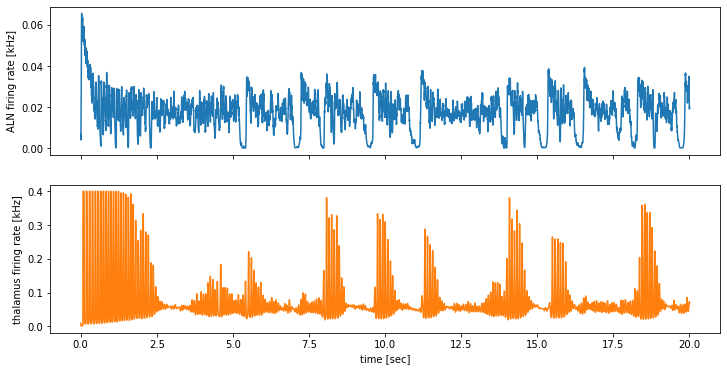

In [16]:
_, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
axs[0].plot(thalamocortical.t, thalamocortical.r_mean_EXC[0, :].T)
axs[0].set_ylabel("ALN firing rate [kHz]")
axs[1].plot(thalamocortical.t, thalamocortical.r_mean_EXC[1, :].T, color="C1")
axs[1].set_ylabel("thalamus firing rate [kHz]")
axs[1].set_xlabel("time [sec]")

We can nicely see the interplay between cortical UP and DOWN states (with UP state being dominant and irregular DOWN state excursions) and thalamic spindles.

Combining different models might seem hard at first, but it is actually kind of intuitive and works as you would connect models with pen and paper.
The only necessary thing is to define and initialize individual nodes in the network (done in `__init__` function) and then specify the type of coupling between these nodes (in `_sync()` function). That's it!

For more information on how to build a network and for a deeper understanding of how exactly `MultiModel` works, please check out our following example, where we will build the Jansen-Rit network from scratch!